In [1]:
import torch
from torch import nn
import numpy as np 
from typing import Dict, Tuple, List, Optional
import math, time, os

import import_ipynb
from TrainFunctions import (
    cross_entropy_loss,
    AdamW,
    cosine_lr_schedule,
    clip_gradients,
    get_batch,
    save_checkpoint,
    load_checkpoint,
    load_token_dataset, 
    TrainingConfig,
)
from TransformerLM import TransformerLM

./TrainLoopFiles/checkpoints


In [2]:
def load_token_dataset(path: str) -> np.memmap: # 0-准备数据 | 读取 .npy 数据集
    arr = np.load(path, mmap_mode="r")
    print(f"max token id: {int(arr.max())}")
    return arr 

## 1-评估函数
- 随机抽 num_batches 组 batch
- 计算平均 loss

In [3]:
@torch.no_grad()
def evaluate_model_loss(
    model: nn.Module, 
    data: np.ndarray, 
    config: TrainingConfig, 
    num_batches: int = 20, 
) -> float: 
    model.eval() # 评估模式
    
    losses = []

    for _ in range(num_batches): 
        x, y = get_batch(
            data, 
            batch_size=config.batch_size, 
            context_len=config.context_len, 
            device=config.device,
        )
        logits = model(x) # (B, T, vocab) 前向传播 forward
        loss = cross_entropy_loss(logits, y) 
        losses.append(loss.item())

    model.train() # 训练模式
    return float(sum(losses) / len(losses))

## 2-实时更新训练/验证 loss 曲线
调用示例
```python
plotter = LivePlotter()

for step in range(num_steps):
    loss = train_step()
    plotter.log_train(step, loss)

    if step % 100 == 0:
        val_loss = evaluate()
        plotter.log_eval(step, val_loss)
        plotter.draw()
```

In [4]:
from IPython.display import clear_output
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt

set_matplotlib_formats('svg') # svg 绘制

class LivePlotter:
    def __init__(self, dpi=200):
        self.train_steps = []
        self.train_losses = []
        self.eval_steps = []
        self.eval_losses = []
        self.dpi = dpi

    def log_train(self, step, loss):
        self.train_steps.append(step)
        self.train_losses.append(loss)

    def log_eval(self, step, loss):
        self.eval_steps.append(step)
        self.eval_losses.append(loss)

    def draw(self):
        clear_output(wait=True)
        plt.figure(figsize=(6, 4), dpi=self.dpi)
        if self.train_steps:
            plt.plot(self.train_steps, self.train_losses, label="train_loss", color="#1f77b4")
        if self.eval_steps:
            plt.plot(self.eval_steps, self.eval_losses, label="val_loss", color="#ff7f0e")
        plt.xlabel("step")
        plt.ylabel("loss")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.title("Training Progress")
        plt.tight_layout()
        plt.show()

    def save(self, path: str = "loss_curve.png"): # 保存当前训练曲线到文件
        plt.figure(figsize=(6, 4), dpi=self.dpi)
        if self.train_steps:
            plt.plot(self.train_steps, self.train_losses, label="train_loss", color="#1f77b4")
        if self.eval_steps:
            plt.plot(self.eval_steps, self.eval_losses, label="val_loss", color="#ff7f0e")
        plt.xlabel("step")
        plt.ylabel("loss")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(path)
        plt.close()
        print(f"[plotter] Saved training curve to {path}")


## 3-构建模型、优化器
- 构建 TransformerLM
- 构建 AdamW

In [5]:
def create_model_and_optimizer(cfg: TrainingConfig, ckpt_path_to_resume: str=None): 
    device = cfg.device

    model = TransformerLM( # 定义模型
        vocab_size=cfg.vocab_size, 
        d_model=cfg.d_model, 
        num_heads=cfg.num_heads, 
        num_layers=cfg.num_layers, 
        max_seq_len=cfg.context_len, 
    )
    model.to(device)

    optimizer = AdamW( # 定义优化器
        model.parameters(), 
        lr=cfg.lr_max, # 默认学习率，会被覆盖掉
        betas=cfg.betas, 
        eps=cfg.eps, 
        weight_decay=cfg.weight_decay, 
    )

    start_step = 0 # 定义断点
    if ckpt_path_to_resume is not None and os.path.exists(ckpt_path_to_resume): 
        print(f"[resume] Loading checkpoint from {ckpt_path_to_resume}")
        start_step = load_checkpoint(model, optimizer, ckpt_path_to_resume)

    return model, optimizer, start_step

## 4-训练循环

### 每个 step
> 为什么是 step 而不是 epoch？
> 语言模型的训练是流式的(通常不是封闭训练集)，不需要固定的 epoch 概念
> 学习率调度按照 step 定义，每步精确控制
> 数据随机采样，不会遍历所有样本

- 抽 batch
- 计算当前 step 学习率 -> optimizer
- loss 计算(cross_entropy_loss)
- backward -> clip_gradient
- optimizer.step() | zero_grad()

### 训练日志/说明
- 每隔 `log_every` 记录 train loss
- 每隔 `eval_every` 在 validation 上跑 evaluate_model_loss
- 每隔 `ckpt_every` 保存 checkpoint
- 用 LivePlotter 实时画图

### 参数集合
```python
@dataclass
class TrainingConfig:
    # === Data / batching ===
    batch_size: int = 32
    context_len: int = 256
    vocab_size: int = 10000  # tokenizer vocab size

    # === Model architecture ===
    num_layers: int = 12
    num_heads: int = 16
    d_model: int = 1024
    d_ff: int = field(default=None)  # 默认按 8/3*d_model 计算
    rope_theta: float = 10000.0

    # === Training steps ===
    total_steps: int = 10_000
    log_every: int = 50
    eval_every: int = 500
    ckpt_every: int = 1000

    # === Optimizer (AdamW) ===
    lr_max: float = 3e-4
    lr_min: float = 3e-5
    betas: Tuple[float, float] = (0.9, 0.95)
    eps: float = 1e-8
    weight_decay: float = 0.1
    grad_clip_norm: float = 1.0

    # === Scheduler ===
    warmup_iters: int = 200
    cosine_iters: int = 10000  # after this, lr = lr_min

    # === Misc ===
    device: str = "cuda"
    ckpt_dir: str = "./checkpoints"
    ckpt_save_prefix: str = "checkpoint"
    log_dir: str = "./logs"
    log_save_prefix: str = "train"

```

In [6]:
def train_loop(
    train_data: np.ndarray, 
    val_data: np.ndarray, 
    cfg: TrainingConfig,
): 
    device = cfg.device
    total_steps = cfg.total_steps
    os.makedirs(cfg.target_dir, exist_ok=True)
    os.makedirs(cfg.log_dir, exist_ok=True)
    os.makedirs(cfg.ckpt_dir, exist_ok=True)
    log_path = os.path.join(cfg.log_dir, f"{cfg.log_save_prefix}.log")
    log_file = open(log_path, "a", encoding="utf-8")
    log_file.write(f"=== Training started at {time.ctime()} ===\n")
    
    model, optimizer, start_step = create_model_and_optimizer(cfg, cfg.ckpt_path_to_resume)

    plotter = LivePlotter() 

    for cur_step in range(start_step, total_steps): 
        x, y = get_batch(
            train_data, 
            batch_size=cfg.batch_size, 
            context_len=cfg.context_len, 
            device=device, 
        )

        lr_t = cosine_lr_schedule(
            t=cur_step, 
            lr_max=cfg.lr_max, 
            lr_min=cfg.lr_min, 
            warmup_iters=cfg.warmup_iters, 
            cosine_iters=cfg.cosine_iters, 
        )
        for g in optimizer.param_groups: # 计算学习率并更新
            g["lr"] = lr_t 

        logits = model(x)
        loss = cross_entropy_loss(logits, y) # 计算当前 step 损失

        optimizer.zero_grad(set_to_none=True)
        loss.backward() # 计算梯度
        grad_norm = clip_gradients(model.parameters(), cfg.grad_clip_norm) # 梯度裁剪

        optimizer.step() # 更新参数

        if cur_step % cfg.log_every == 0: # 训练日志
            loss_val = float(loss.item())
            msg = (
                f"[{time.strftime('%H:%M:%S')}] "
                f"step {cur_step:06d} "
                f"loss {loss_val:.4f} "
                f"lr {lr_t:.2e} "
                f"grad_norm {grad_norm:.2f}"
            )
            log_file.write(msg + "\n") 
            log_file.flush()
            plotter.log_train(cur_step, loss_val)

        if (cur_step % cfg.eval_every == 0 and cur_step > 0) or cur_step == total_steps - 1: # 验证
            with torch.no_grad(): 
                val_loss = evaluate_model_loss(model, val_data, cfg) 
            val_msg = f"[VAL] step {cur_step:06d} val_loss {val_loss:.4f}"
            log_file.write(val_msg + "\n") 
            log_file.flush() 
            plotter.log_eval(cur_step, val_loss)

        if cur_step % cfg.log_every == 0: # 绘图刷新
            plotter.draw() 

        if cur_step % cfg.ckpt_every == 0 and cur_step > 0: # Checkpoint 保存
            ckpt_path = os.path.join(cfg.ckpt_dir, f"{cfg.ckpt_save_prefix}_{cur_step}.pt")
            save_checkpoint(model, optimizer, cur_step, ckpt_path)
            log_file.write(f"[CKPT] Saved to {ckpt_path}\n")
            log_file.flush()

    final_ckpt = os.path.join(cfg.ckpt_dir, f"{cfg.ckpt_save_prefix}_final.pt")
    save_checkpoint(model, optimizer, total_steps, final_ckpt)
    log_file.write(f"=== Training finished at {time.ctime()} ===\n")
    log_file.close()

    plotter.draw() 
    plot_path = os.path.join(cfg.log_dir, f"{cfg.log_save_prefix}_loss_curve.png")
    plotter.save(plot_path)
    return model

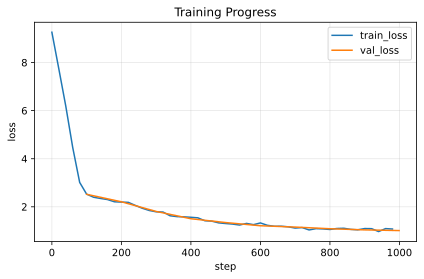

[plotter] Saved training curve to ./TrainLoopFiles/logs_localhost/train_localhost_loss_curve.png


In [9]:
train_data = load_token_dataset("./datasets/tokens_valid.npy")
val_data = load_token_dataset("./datasets/tokens_valid.npy")

cfg = TrainingConfig(
    batch_size=16,
    context_len=256,
    total_steps=1000,
    log_every=20,
    eval_every=100,
    ckpt_every=250,
    lr_max=6e-4,
    lr_min=6e-5,
    warmup_iters=300,
    cosine_iters=1000,
    weight_decay=0.05,
    grad_clip_norm=1.0,
    vocab_size=10000, 
    num_layers=6,
    d_model=512,
    num_heads=8,
    d_ff=None, # TrainingConfig自动推导
    device="cuda", 
    ckpt_dir="./TrainLoopFiles/checkpoints_localhost",
    ckpt_save_prefix="checkpoint",
    log_dir="./TrainLoopFiles/logs_localhost",
    log_save_prefix="train_localhost",
    ckpt_path_to_resume=None,
)

trained_model = train_loop(
    train_data=train_data, 
    val_data=val_data, 
    cfg=cfg,
)